In [75]:
%load_ext autoreload
%autoreload 2

import numpy as np

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Sequential, Input
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

import pandas as pd

from sklearn.metrics import accuracy_score, f1_score, roc_curve, confusion_matrix, roc_auc_score
from sklearn.utils import compute_class_weight

import scipy.stats

import seaborn as sns

print(tf.test.is_built_with_cuda())
gpu_available = tf.config.list_physical_devices('GPU')
print(gpu_available)

from config import img_size, batch_size, model_path


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load the data

In [23]:
def load_data():
    df = pd.read_csv("data/HAM10000_metadata.csv")
    df["label"] = df["dx"].apply(lambda dx: "malignant" if dx in ["akiec", "bcc", "mel"] else "benign") 
    #https://arxiv.org/ftp/arxiv/papers/1803/1803.10417.pdf
    df["image_id"] = df["image_id"].apply(lambda id: f"{id}.jpg")
    df = df.sample(frac=1, random_state=0)
    training_df = df[:8000]
    validation_df = df[8000:9000]
    testing_df = df[9000:]
    classes=["benign", "malignant"]
    
    training_data_generator = ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=360,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.95, 1.05],
        zoom_range=[0.85, 1.15]
    )

    validation_data_generator = ImageDataGenerator(
        rescale=1.0/255
    )
    
    testing_data_generator = ImageDataGenerator(
        rescale=1.0/255
    )
    
    training_data = training_data_generator.flow_from_dataframe(
        dataframe= training_df,
        directory="data/images_cropped",
        x_col="image_id",
        y_col="label",
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="binary",
        classes=classes,
        shuffle=True,
        
    )

    validation_data = validation_data_generator.flow_from_dataframe(
        dataframe=validation_df,
        directory="data/images_cropped",
        x_col="image_id",
        y_col="label",
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="binary",
        classes=classes,
        shuffle=True
    )

    test_data = testing_data_generator.flow_from_dataframe(
        dataframe=testing_df,
        directory="data/images_cropped",
        x_col="image_id",
        y_col="label",
        target_size=(img_size, img_size),
        class_mode="binary",
        classes=classes,
        batch_size=1015,
        shuffle=False
    )

    return training_data, validation_data, test_data

### Creating the model
Explanation of why the model looks like it does

In [24]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras import Model



def create_model():
    #model = Sequential()
    #model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
    #model.add(layers.MaxPooling2D((2, 2)))
    #model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    #model.add(layers.Flatten())
    #model.add(layers.Dense(64, activation='relu'))
    #model.add(layers.Dense(7, activation='softmax'))

    #model =  Sequential()
    #model.add(layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', padding='valid', input_shape=(img_size, img_size, 3)))
    #model.add(layers.MaxPool2D((3, 3), strides=(2, 2), padding='valid'))
    #model.add(layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu'))
    #model.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))
    #model.add(layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    #model.add(layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    #model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    #model.add(layers.Flatten())
    #model.add(layers.Dense(4096, activation='relu'))
    #model.add(layers.Dense(4096, activation='relu'))
    #model.add(layers.Dense(1, activation='sigmoid'))
    
    
    
    model = InceptionV3(
        input_shape=(img_size, img_size, 3), pooling="max", include_top=True, classes=1, classifier_activation="sigmoid", weights=None
    )
    
    
    model.compile(optimizer='adam', loss=[BinaryCrossentropy(from_logits=False)], weighted_metrics=[AUC(name="auc",  curve='ROC'), BinaryAccuracy(name="accuracy")])

    return model

### Training the model

In [25]:
def train_model(model, training_data, validation_data, epochs=2):
    
    model_checkpoint_callback = ModelCheckpoint(
        filepath=model_path,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )
    
    csv_logger = CSVLogger(f'{model_path}/history.csv', append=False)
    
    # Automatically compute class weights based on label percentage
    y_train = training_data.labels
    class_weight = dict(enumerate(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)))
    print(f'Class weights: {class_weight}')
    
    history = model.fit(training_data, epochs=epochs, validation_data=validation_data, verbose=1, class_weight=class_weight, callbacks=[model_checkpoint_callback, csv_logger])
    return history

### Evaluate the model

In [26]:
def evaluate_model(model, test_data):
    y_true = test_data[0][1]
    x = test_data[0][0]
    y_score = model.predict(x)
    y_pred = [round(y[0]) for y in y_score]
    
    data_tuple = test_data[0]
    inputs = data_tuple[0]
    predicted = model.predict(inputs)
    ground_truth = [x[1] for x in data_tuple[1]]
    predictions = [x[1] for x in predicted]
    rounded_ground_truth = [round(x) for x in ground_truth]
    rounded_predictions = [round(x) for x in predictions]
    print("---- Ground truth ----")
    print(f"Min: {np.min(y_true)}")
    print(f"Max: {np.max(y_true)}")
    print(f"Mean: {np.mean(y_true)}")
    print("---- Predictions ----")
    print(f"Min: {np.min(y_score)}")
    print(f"Max: {np.max(y_score)}")
    print(f"Mean: {np.mean(y_score)}")
    print(f"Mean rounded: {np.mean(rounded_predictions)}")
    return accuracy_score(rounded_ground_truth, rounded_predictions), f1_score(rounded_ground_truth, rounded_predictions)

Comments on the results

In [27]:
def save_model(model, path):
    model.save(path)

### Putting it all together

In [28]:
model = create_model()
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 149, 149, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_282 (Batch  (None, 149, 149, 32  96         ['conv2d_282[0][0]']             
 Normalization)                 )                                                      

 conv2d_293 (Conv2D)            (None, 35, 35, 32)   6144        ['average_pooling2d_27[0][0]']   
                                                                                                  
 batch_normalization_287 (Batch  (None, 35, 35, 64)  192         ['conv2d_287[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_289 (Batch  (None, 35, 35, 64)  192         ['conv2d_289[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_292 (Batch  (None, 35, 35, 96)  288         ['conv2d_292[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_304 (Conv2D)            (None, 35, 35, 64)   18432       ['mixed1[0][0]']                 
                                                                                                  
 batch_normalization_304 (Batch  (None, 35, 35, 64)  192         ['conv2d_304[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_304 (Activation)    (None, 35, 35, 64)   0           ['batch_normalization_304[0][0]']
                                                                                                  
 conv2d_302 (Conv2D)            (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_30

                                                                                                  
 activation_311 (Activation)    (None, 17, 17, 96)   0           ['batch_normalization_311[0][0]']
                                                                                                  
 max_pooling2d_14 (MaxPooling2D  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
 )                                                                                                
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_308[0][0]',         
                                                                  'activation_311[0][0]',         
                                                                  'max_pooling2d_14[0][0]']       
                                                                                                  
 conv2d_31

 mixed4 (Concatenate)           (None, 17, 17, 768)  0           ['activation_312[0][0]',         
                                                                  'activation_315[0][0]',         
                                                                  'activation_320[0][0]',         
                                                                  'activation_321[0][0]']         
                                                                                                  
 conv2d_326 (Conv2D)            (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_326 (Batch  (None, 17, 17, 160)  480        ['conv2d_326[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 conv2d_336 (Conv2D)            (None, 17, 17, 160)  122880      ['mixed5[0][0]']                 
                                                                                                  
 batch_normalization_336 (Batch  (None, 17, 17, 160)  480        ['conv2d_336[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_336 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_336[0][0]']
                                                                                                  
 conv2d_337 (Conv2D)            (None, 17, 17, 160)  179200      ['activation_336[0][0]']         
                                                                                                  
 batch_normalization_337 (Batch  (None, 17, 17, 160)  480        ['conv2d_337[0][0]']             
 Normaliza

 activation_346 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_346[0][0]']
                                                                                                  
 conv2d_347 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_346[0][0]']         
                                                                                                  
 batch_normalization_347 (Batch  (None, 17, 17, 192)  576        ['conv2d_347[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_347 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_347[0][0]']
                                                                                                  
 conv2d_343 (Conv2D)            (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
          

 Normalization)                                                                                   
                                                                                                  
 activation_355 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_355[0][0]']
                                                                                                  
 conv2d_352 (Conv2D)            (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_356 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_355[0][0]']         
                                                                                                  
 batch_normalization_352 (Batch  (None, 17, 17, 192)  576        ['conv2d_352[0][0]']             
 Normalization)                                                                                   
          

 Normalization)                                                                                   
                                                                                                  
 conv2d_366 (Conv2D)            (None, 8, 8, 192)    245760      ['average_pooling2d_34[0][0]']   
                                                                                                  
 batch_normalization_358 (Batch  (None, 8, 8, 320)   960         ['conv2d_358[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_360 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_360[0][0]']
                                                                                                  
 activation_361 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_361[0][0]']
          

                                                                                                  
 activation_369 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_369[0][0]']
                                                                                                  
 activation_370 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_370[0][0]']
                                                                                                  
 activation_373 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_373[0][0]']
                                                                                                  
 activation_374 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_374[0][0]']
                                                                                                  
 batch_normalization_375 (Batch  (None, 8, 8, 192)   576         ['conv2d_375[0][0]']             
 Normaliza

In [29]:
training_data, validation_data, test_data = load_data()
training_result = train_model(model, training_data, validation_data, epochs=240)

Found 8000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1015 validated image filenames belonging to 2 classes.
Class weights: {0: 0.6208288064566196, 1: 2.5690430314707773}
Epoch 1/240
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
500/500 [==============================] - ETA: 0s - loss: 0.6299 - auc: 0.7129 - accuracy: 0.6669WARNING:tensorflow:Auto

INFO:tensorflow:Assets written to: models/test\checkpoint\assets
500/500 [==============================] - 159s 318ms/step - loss: 0.5523 - auc: 0.7800 - accuracy: 0.7122 - val_loss: 1.1011 - val_auc: 0.5770 - val_accuracy: 0.7880
Epoch 4/240
500/500 [==============================] - ETA: 0s - loss: 0.5220 - auc: 0.7962 - accuracy: 0.7272WARNING:tensorflow:AutoGraph could not transform <function trace_model_call.<locals>._wrapped_model at 0x00000208624924C8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'


INFO:tensorflow:Assets written to: models/test\checkpoint\assets
500/500 [==============================] - 159s 317ms/step - loss: 0.4813 - auc: 0.8300 - accuracy: 0.7561 - val_loss: 0.3782 - val_auc: 0.8472 - val_accuracy: 0.8100
Epoch 17/240
500/500 [==============================] - 125s 250ms/step - loss: 0.4865 - auc: 0.8279 - accuracy: 0.7543 - val_loss: 0.4625 - val_auc: 0.8531 - val_accuracy: 0.7550
Epoch 18/240
500/500 [==============================] - 127s 254ms/step - loss: 0.4910 - auc: 0.8279 - accuracy: 0.7576 - val_loss: 0.4955 - val_auc: 0.8474 - val_accuracy: 0.7130
Epoch 19/240
500/500 [==============================] - 127s 254ms/step - loss: 0.4845 - auc: 0.8307 - accuracy: 0.7600 - val_loss: 0.4958 - val_auc: 0.8413 - val_accuracy: 0.7210
Epoch 20/240
500/500 [==============================] - 128s 256ms/step - loss: 0.4732 - auc: 0.8385 - accuracy: 0.7639 - val_loss: 0.4088 - val_auc: 0.8540 - val_accuracy: 0.7790
Epoch 21/240
500/500 [==========================

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: models/test\checkpoint\assets
500/500 [==============================] - 161s 321ms/step - loss: 0.4463 - auc: 0.8591 - accuracy: 0.7782 - val_loss: 0.3491 - val_auc: 0.8724 - val_accuracy: 0.8310
Epoch 48/240
500/500 [==============================] - 127s 253ms/step - loss: 0.4414 - auc: 0.8631 - accuracy: 0.7860 - val_loss: 0.3835 - val_a

500/500 [==============================] - 128s 256ms/step - loss: 0.4313 - auc: 0.8704 - accuracy: 0.7896 - val_loss: 0.4612 - val_auc: 0.7203 - val_accuracy: 0.7900
Epoch 66/240
500/500 [==============================] - 130s 259ms/step - loss: 0.4270 - auc: 0.8723 - accuracy: 0.7935 - val_loss: 0.3536 - val_auc: 0.8828 - val_accuracy: 0.8250
Epoch 67/240
500/500 [==============================] - 130s 259ms/step - loss: 0.4319 - auc: 0.8707 - accuracy: 0.7919 - val_loss: 0.3541 - val_auc: 0.9062 - val_accuracy: 0.8180
Epoch 68/240
500/500 [==============================] - 130s 259ms/step - loss: 0.4228 - auc: 0.8743 - accuracy: 0.7961 - val_loss: 0.3525 - val_auc: 0.8946 - val_accuracy: 0.8170
Epoch 69/240
500/500 [==============================] - 128s 256ms/step - loss: 0.4240 - auc: 0.8720 - accuracy: 0.7982 - val_loss: 0.3318 - val_auc: 0.9056 - val_accuracy: 0.8200
Epoch 70/240
500/500 [==============================] - 128s 255ms/step - loss: 0.4251 - auc: 0.8740 - accuracy: 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: models/test\checkpoint\assets
500/500 [=

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: models/test\checkpoint\assets
500/500 [==============================] - 164s 327ms/step - loss: 0.3987 - auc: 0.8914 - accuracy: 0.8088 - val_loss: 0.2877 - val_auc: 0.9159 - val_accuracy: 0.8660
Epoch 108/240
500/500 [==============================] - 129s 257ms/step - loss: 0.3955 - auc: 0.8926 - accuracy: 0.8166 - val_loss: 0.3283 - val_auc: 0.8858 - val_accuracy: 0.8430
Epoch 109/240
500/500 [==============================] - 131s 261ms/step - loss: 0.3946 - auc: 0.8931 - accuracy: 0.8151 - val_loss: 0.2903 - val_auc: 0.9114 - val_accuracy: 0.8660
Epoch 110/240
500/500 [==============================] - 130s 260ms/step - loss: 0.3980 - auc: 

500/500 [==============================] - 129s 258ms/step - loss: 0.3736 - auc: 0.9049 - accuracy: 0.8209 - val_loss: 0.3059 - val_auc: 0.9059 - val_accuracy: 0.8540
Epoch 150/240
500/500 [==============================] - 155s 309ms/step - loss: 0.3724 - auc: 0.9073 - accuracy: 0.8238 - val_loss: 0.3196 - val_auc: 0.8955 - val_accuracy: 0.8360
Epoch 151/240
500/500 [==============================] - 136s 271ms/step - loss: 0.3723 - auc: 0.9048 - accuracy: 0.8260 - val_loss: 0.3061 - val_auc: 0.9112 - val_accuracy: 0.8510
Epoch 152/240
500/500 [==============================] - 132s 264ms/step - loss: 0.3794 - auc: 0.9034 - accuracy: 0.8258 - val_loss: 0.3001 - val_auc: 0.9166 - val_accuracy: 0.8580
Epoch 153/240
500/500 [==============================] - 131s 262ms/step - loss: 0.3706 - auc: 0.9067 - accuracy: 0.8277 - val_loss: 0.3020 - val_auc: 0.9073 - val_accuracy: 0.8470
Epoch 154/240
500/500 [==============================] - 129s 258ms/step - loss: 0.3678 - auc: 0.9084 - accur

INFO:tensorflow:Assets written to: models/test\checkpoint\assets
500/500 [==============================] - 164s 328ms/step - loss: 0.3545 - auc: 0.9162 - accuracy: 0.8350 - val_loss: 0.2845 - val_auc: 0.9169 - val_accuracy: 0.8690
Epoch 186/240
500/500 [==============================] - 128s 255ms/step - loss: 0.3524 - auc: 0.9175 - accuracy: 0.8347 - val_loss: 0.3203 - val_auc: 0.9123 - val_accuracy: 0.8520
Epoch 187/240
500/500 [==============================] - 128s 255ms/step - loss: 0.3489 - auc: 0.9175 - accuracy: 0.8358 - val_loss: 0.3690 - val_auc: 0.8931 - val_accuracy: 0.8180
Epoch 188/240
500/500 [==============================] - 129s 258ms/step - loss: 0.3492 - auc: 0.9195 - accuracy: 0.8402 - val_loss: 0.3548 - val_auc: 0.8918 - val_accuracy: 0.8280
Epoch 189/240
500/500 [==============================] - 128s 256ms/step - loss: 0.3514 - auc: 0.9180 - accuracy: 0.8342 - val_loss: 0.3053 - val_auc: 0.9031 - val_accuracy: 0.8410
Epoch 190/240
500/500 [=====================

Epoch 230/240
500/500 [==============================] - 128s 255ms/step - loss: 0.3231 - auc: 0.9306 - accuracy: 0.8527 - val_loss: 0.3056 - val_auc: 0.9125 - val_accuracy: 0.8490
Epoch 231/240
500/500 [==============================] - 128s 256ms/step - loss: 0.3274 - auc: 0.9294 - accuracy: 0.8505 - val_loss: 0.3180 - val_auc: 0.9044 - val_accuracy: 0.8520
Epoch 232/240
500/500 [==============================] - 127s 254ms/step - loss: 0.3248 - auc: 0.9308 - accuracy: 0.8476 - val_loss: 0.3320 - val_auc: 0.9121 - val_accuracy: 0.8420
Epoch 233/240
500/500 [==============================] - 127s 254ms/step - loss: 0.3280 - auc: 0.9301 - accuracy: 0.8510 - val_loss: 0.2921 - val_auc: 0.9115 - val_accuracy: 0.8510
Epoch 234/240
500/500 [==============================] - 129s 257ms/step - loss: 0.3199 - auc: 0.9324 - accuracy: 0.8510 - val_loss: 0.3034 - val_auc: 0.9100 - val_accuracy: 0.8590
Epoch 235/240
500/500 [==============================] - 128s 256ms/step - loss: 0.3287 - auc: 

In [30]:
#save_model(model, model_path)

In [40]:
model = tf.keras.models.load_model(model_path)
training_data, validation_data, test_data = load_data()

Found 8000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1015 validated image filenames belonging to 2 classes.


In [41]:
# test_result = evaluate_model(model, test_data)
# print(f"Accuracy: {test_result[0]}")
# print(f"F1-score: {test_result[1]}")


In [127]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(training_result.history)

hist_csv_file = f'./{model_path}/history.csv'

hist_df.to_csv(hist_csv_file)

In [128]:
history = pd.read_csv(hist_csv_file)

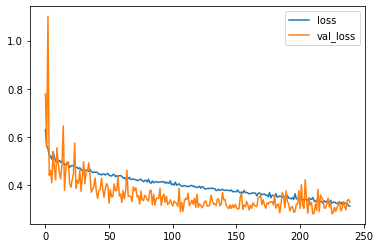

In [129]:
labels = ["loss", "val_loss"]
for label in labels:
     plt.plot(history[label])
plt.legend(labels)
plt.show()

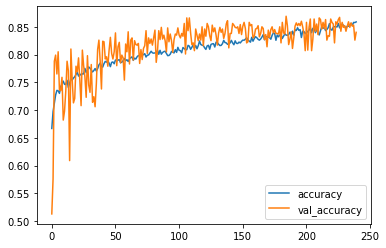

In [130]:
labels = ["accuracy", "val_accuracy"]
for label in labels:
    plt.plot(history[label])
plt.legend(labels)
plt.show()

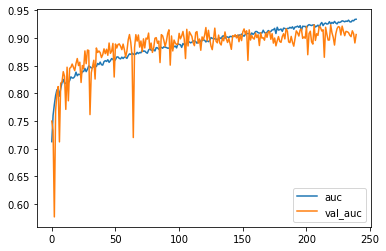

In [131]:
labels = ["auc", "val_auc"]
for label in labels:
    plt.plot(history[label])
plt.legend(labels)
plt.show()

In [89]:
def plot_cm(y_true, y_score, threshold=0.5):
    y_pred = [0 if y[0] < threshold else 1 for y in y_score]
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f'Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

def plot_roc(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    
    # plot the roc curve for the model
    plt.figure(figsize=(8,8))
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='model')
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    # axis labels
    plt.title(f'Receiver operating characteristic (ROC) with {round(roc_auc_score(y_true, y_score), 3)} AUC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    # show the plot
    plt.show()
    
def plot_prediction_distributions(y_true, y_score, threshold):
    test_y = y_true
    predicted_y_probs = y_score

    def estimate_beta(X):
        xbar = np.mean(X)
        vbar = np.var(X,ddof=1)
        alphahat = xbar*(xbar*(1-xbar)/vbar - 1)
        betahat = (1-xbar)*(xbar*(1-xbar)/vbar - 1)
        return alphahat, betahat

    positive_beta_estimates = estimate_beta(predicted_y_probs[test_y == 1])
    negative_beta_estimates = estimate_beta(predicted_y_probs[test_y == 0])

    unit_interval = np.linspace(0,1,100)
    plt.plot(unit_interval, scipy.stats.beta.pdf(unit_interval, *positive_beta_estimates), c='r', label="positive")
    plt.plot(unit_interval, scipy.stats.beta.pdf(unit_interval, *negative_beta_estimates), c='g', label="negative")

    # Show the threshold.
    plt.axvline(threshold, c='black', ls='dashed')
    plt.xlim(0,1)
    plt.yticks([], [])

    # Add labels
    plt.legend()
    

In [61]:
y_true = test_data[0][1]
x = test_data[0][0]
y_score = model.predict(x)


Best Threshold=0.197710, G-Mean=0.828


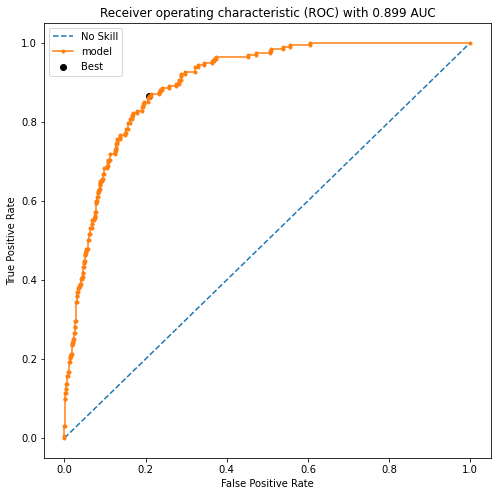

In [85]:
plot_roc(y_true, y_score)

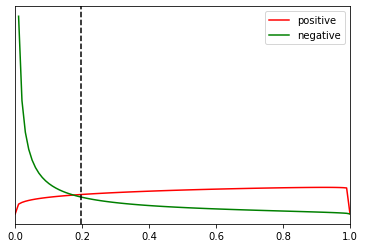

In [90]:
plot_prediction_distributions(y_true, y_score, 0.197710)

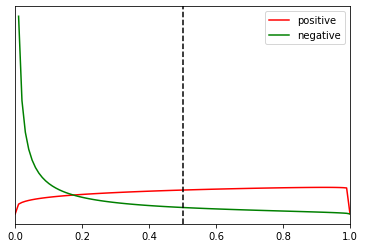

In [91]:
plot_prediction_distributions(y_true, y_score, 0.5)

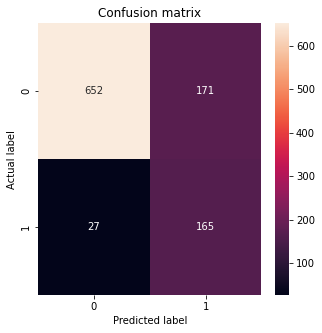

In [80]:
# Confusion matrix when using the best threshold
plot_cm(y_true, y_score, 0.197710)

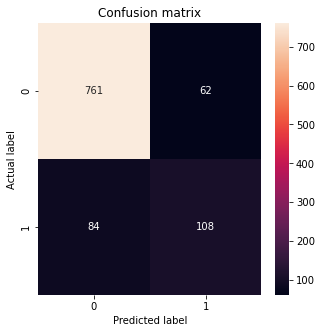

In [81]:
# Confusion matrix when using default 0.5 as threshold
plot_cm(y_true, y_score, 0.5)

(299, 299, 3)


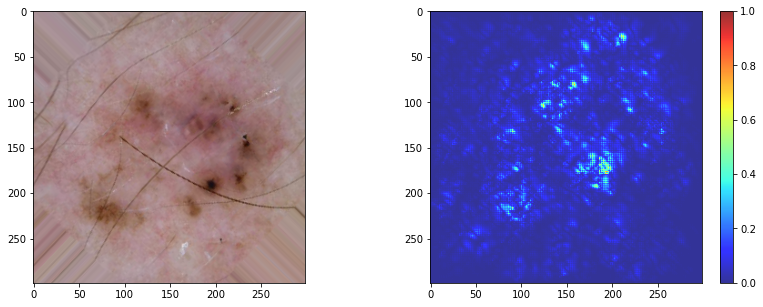

In [117]:
print(training_data[0][0][0].shape)
img = training_data[0][0][0]


images = tf.Variable(np.expand_dims(img, axis=0), dtype=float)

with tf.GradientTape() as tape:
    pred = model(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
    loss = pred[0][class_idxs_sorted[0]]
    
grads = tape.gradient(loss, images)

dgrad_abs = tf.math.abs(grads)

dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].imshow(img)
i = ax[1].imshow(grad_eval,cmap="jet",alpha=0.8)
fig.colorbar(i)